In [1]:
import shutil
import random

import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from keras.layers import Dense, Activation,Reshape, Dropout
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from keras.preprocessing import image
from keras.models import Model
from keras.applications import imagenet_utils
from keras.models import load_model

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
random.seed(10)
np.random.seed(10)
tf.random.set_seed(10)

In [3]:
train_path = r"C:\Users\Administrator\Desktop\Folder\image_folder\class_images\split\train"
valid_path =  r"C:\Users\Administrator\Desktop\Folder\image_folder\class_images\split\val"
test_path =  r"C:\Users\Administrator\Desktop\Folder\image_folder\class_images\split\test"

In [4]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg19.preprocess_input).flow_from_directory(
    directory=train_path, target_size=(224,224), batch_size=32)

valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg19.preprocess_input).flow_from_directory(
    directory=valid_path, target_size=(224,224), batch_size=32)

test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg19.preprocess_input).flow_from_directory(
    directory=test_path, target_size=(224,224), batch_size=32, shuffle=False)

Found 8342 images belonging to 33 classes.
Found 1030 images belonging to 33 classes.
Found 1074 images belonging to 33 classes.


In [5]:
temp_model=keras.applications.VGG19()
temp_model.summary()
print(len(temp_model.layers))

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [6]:
base_model=keras.applications.VGG19(input_shape=(224,224,3), weights='imagenet', include_top=False)

#Training only the last 2 layers. 
#Freezing the first 22-2=20 layers 
for layer in base_model.layers[:20]:
    layer.trainable = False
    
    
base_model.summary()
print(len(base_model.layers))

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [7]:
for layer in base_model.layers:
    print(layer,layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x000001EF30C3CFD0> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x000001EF30C3D190> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x000001EF147C88E0> False
<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x000001EF30C47730> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x000001EF14785340> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x000001EF30C3DAF0> False
<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x000001EF30C4F280> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x000001EF30C4FD90> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x000001EF30C4FBB0> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x000001EF30C4FAF0> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x000001EF30BE2670> False
<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x000001EF30BF0040> False
<keras.layers.convolutional.conv2d.Conv2D object

In [9]:
from tensorflow.keras.layers import Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.regularizers import l2

x = base_model.output
x = Flatten()(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dense(512, activation='relu')(x)


preds=Dense(33,activation='softmax')(x) #final layer with softmax activation

model=Model(inputs=base_model.input,outputs=preds)
model.summary()
print(len(model.layers))

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [10]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(x=train_batches,
            steps_per_epoch=len(train_batches),
            validation_data=valid_batches,
            validation_steps=len(valid_batches),
            epochs=25,
            verbose=2
)

Epoch 1/25
261/261 - 3102s - loss: 3.1745 - accuracy: 0.8202 - val_loss: 3.0609 - val_accuracy: 0.6398 - 3102s/epoch - 12s/step
Epoch 2/25
261/261 - 2796s - loss: 1.8405 - accuracy: 0.8780 - val_loss: 2.6128 - val_accuracy: 0.7534 - 2796s/epoch - 11s/step
Epoch 3/25
261/261 - 2785s - loss: 1.7107 - accuracy: 0.8847 - val_loss: 2.4312 - val_accuracy: 0.7670 - 2785s/epoch - 11s/step
Epoch 4/25
261/261 - 2972s - loss: 1.6883 - accuracy: 0.8912 - val_loss: 1.8799 - val_accuracy: 0.8417 - 2972s/epoch - 11s/step
Epoch 5/25
261/261 - 2968s - loss: 1.5497 - accuracy: 0.8971 - val_loss: 1.4516 - val_accuracy: 0.8825 - 2968s/epoch - 11s/step
Epoch 6/25
261/261 - 2711s - loss: 1.5694 - accuracy: 0.9010 - val_loss: 2.3012 - val_accuracy: 0.7320 - 2711s/epoch - 10s/step
Epoch 7/25
261/261 - 2701s - loss: 1.4377 - accuracy: 0.9083 - val_loss: 2.5532 - val_accuracy: 0.7146 - 2701s/epoch - 10s/step
Epoch 8/25
261/261 - 2708s - loss: 1.4965 - accuracy: 0.9045 - val_loss: 1.6761 - val_accuracy: 0.8718 -

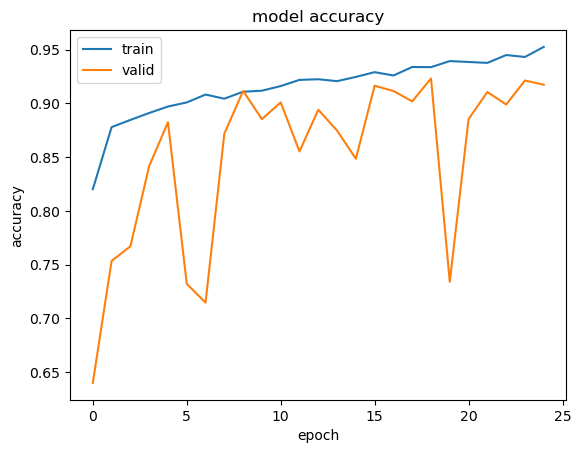

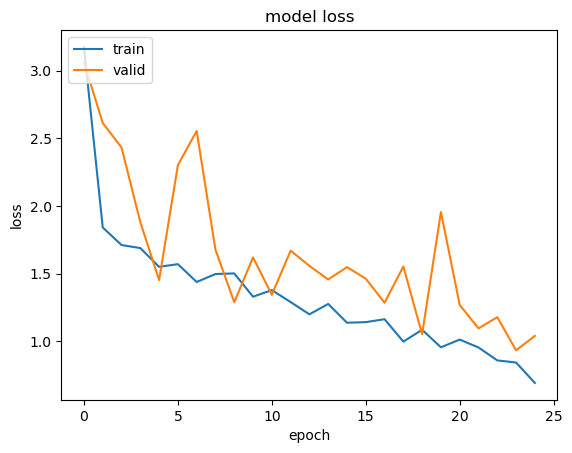

In [11]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [12]:
test_labels = test_batches.classes
predictions = model.predict(x=test_batches, steps=len(test_batches), verbose=0)
cm = confusion_matrix(y_true=test_labels, y_pred=predictions.argmax(axis=1))

In [20]:
y_pred_bool = np.argmax(predictions, axis=1)

print(classification_report(test_labels, y_pred_bool))

              precision    recall  f1-score   support

           0       1.00      0.89      0.94         9
           1       0.79      0.95      0.87        44
           2       0.60      0.30      0.40        10
           3       0.84      0.95      0.89        62
           4       0.94      0.91      0.92        33
           5       0.95      1.00      0.97        18
           6       1.00      0.85      0.92        53
           7       0.95      0.98      0.97        43
           8       0.90      0.90      0.90        59
           9       0.87      0.80      0.83        56
          10       0.91      1.00      0.95        10
          11       0.97      1.00      0.98        32
          12       1.00      0.97      0.98       122
          13       0.95      0.95      0.95        19
          14       1.00      0.85      0.92        20
          15       1.00      0.98      0.99        55
          16       0.00      0.00      0.00        11
          17       0.79    

C:\Users\Administrator\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Administrator\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Administrator\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, m

In [21]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[ 8  0  0 ...  0  0  0]
 [ 0 42  0 ...  0  0  0]
 [ 0  0  3 ...  0  0  0]
 ...
 [ 0  0  0 ... 18  0  0]
 [ 0  0  0 ...  0 16  0]
 [ 0  1  0 ...  0  0 55]]


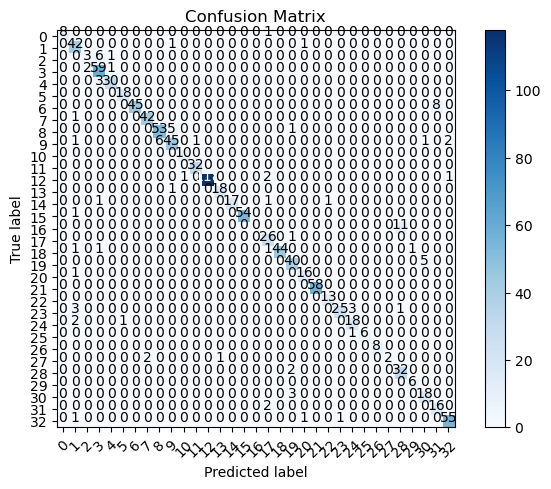

In [22]:
import itertools
test_batches.class_indices

cm_plot_labels = ['0','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','21','22','23','24','25','26','27','28','29','30','31','32']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [23]:
test_labels

array([ 0,  0,  0, ..., 32, 32, 32])

In [24]:
from alibi.explainers import IntegratedGradients

In [25]:
tf. __version__

'2.10.0'

In [26]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg19 import preprocess_input

#load the image
my_image = load_img( r'C:\Users\Administrator\Desktop\Folder\image_folder\class_images\split\test\1\9954.png', target_size=(224, 224))


my_image = img_to_array(my_image)
my_image = my_image.reshape((1, my_image.shape[0], my_image.shape[1], my_image.shape[2]))
my_image = preprocess_input(my_image)

X = my_image

In [27]:
predictions = model.predict(X).argmax(axis=1)
ig = IntegratedGradients(model=model)
explanation = ig.explain(X, target=predictions) #predictions
print(predictions)

1/1 [==============================] - 1s 682ms/step
[1]


In [28]:
# Get attributions values from the explanation object
attrs = explanation.attributions[0]

In [29]:
from alibi.utils import visualize_image_attr

In [30]:
squeezedX = np.squeeze(X)

data = np.array(squeezedX).astype('uint8')

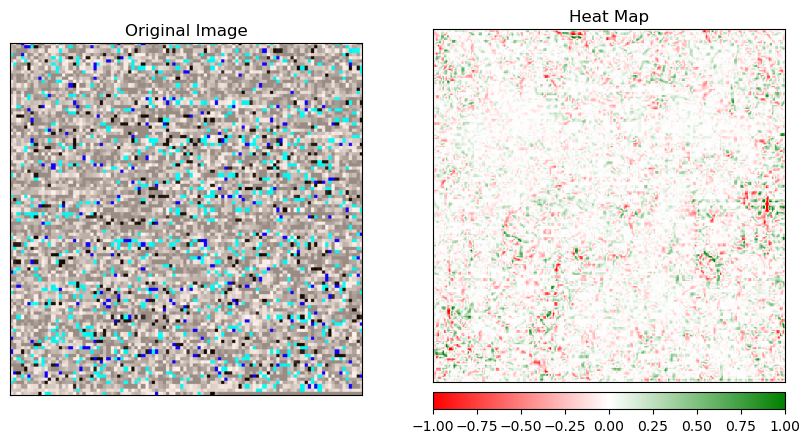

In [31]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
visualize_image_attr(attr=None, original_image=data, method='original_image',
                    title='Original Image', plt_fig_axis=(fig, ax[0]), use_pyplot=False);

visualize_image_attr(attr=attrs.squeeze(), original_image=data, method='heat_map',
                    sign='all', show_colorbar=True, title='Heat Map',
                     plt_fig_axis=(fig, ax[1]), use_pyplot=True);

In [32]:
print(predictions)

[1]
